<a href="https://colab.research.google.com/github/Shu-Hsuan-Lin/MachineLeaning/blob/main/ML_Practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:00<00:00, 116787731.83it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3034708.96it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 62540091.81it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12416490.51it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 5
tt=time.time() #unit:second
train_loss=[]
test_loss=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)

    loss = test(test_dataloader, model, loss_fn)
    test_loss.append(loss)
elapse=time.time()-tt
print("Done!")

Epoch 1
-------------------------------
loss: 2.297572  [   64/60000]
loss: 2.291773  [ 6464/60000]
loss: 2.265793  [12864/60000]
loss: 2.265740  [19264/60000]
loss: 2.258847  [25664/60000]
loss: 2.222295  [32064/60000]
loss: 2.237156  [38464/60000]
loss: 2.204504  [44864/60000]
loss: 2.188574  [51264/60000]
loss: 2.175545  [57664/60000]
Test Error: 
 Accuracy: 39.7%, Avg loss: 2.163083 

Epoch 2
-------------------------------
loss: 2.170185  [   64/60000]
loss: 2.166914  [ 6464/60000]
loss: 2.101032  [12864/60000]
loss: 2.119728  [19264/60000]
loss: 2.088207  [25664/60000]
loss: 2.017253  [32064/60000]
loss: 2.049477  [38464/60000]
loss: 1.971836  [44864/60000]
loss: 1.963653  [51264/60000]
loss: 1.917272  [57664/60000]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.906044 

Epoch 3
-------------------------------
loss: 1.932638  [   64/60000]
loss: 1.914739  [ 6464/60000]
loss: 1.787390  [12864/60000]
loss: 1.831278  [19264/60000]
loss: 1.744205  [25664/60000]
loss: 1.681065  [32064/600

Read more about [Training your model](optimization_tutorial.html).




--------------




plot train/test loss

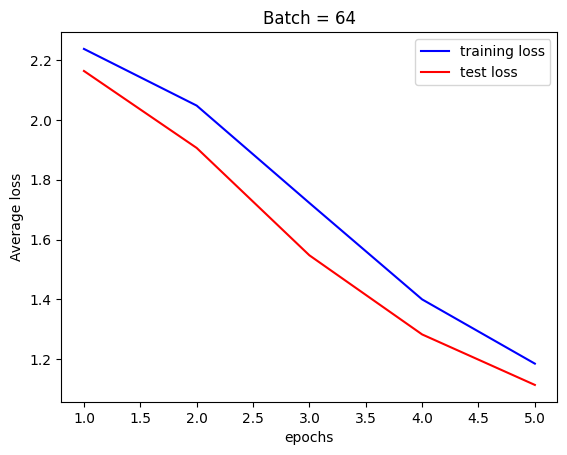

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
plt.legend(["training loss","test loss"])
plt.ylabel("Average loss")
plt.xlabel("epochs")
plt.title("Batch = " + str("%.0f"%batch_size))

#plt.savefig('loss.png')
plt.show()
plt.close()

## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your model](saveloadrun_tutorial.html).




batch size= 64
time58.068514823913574


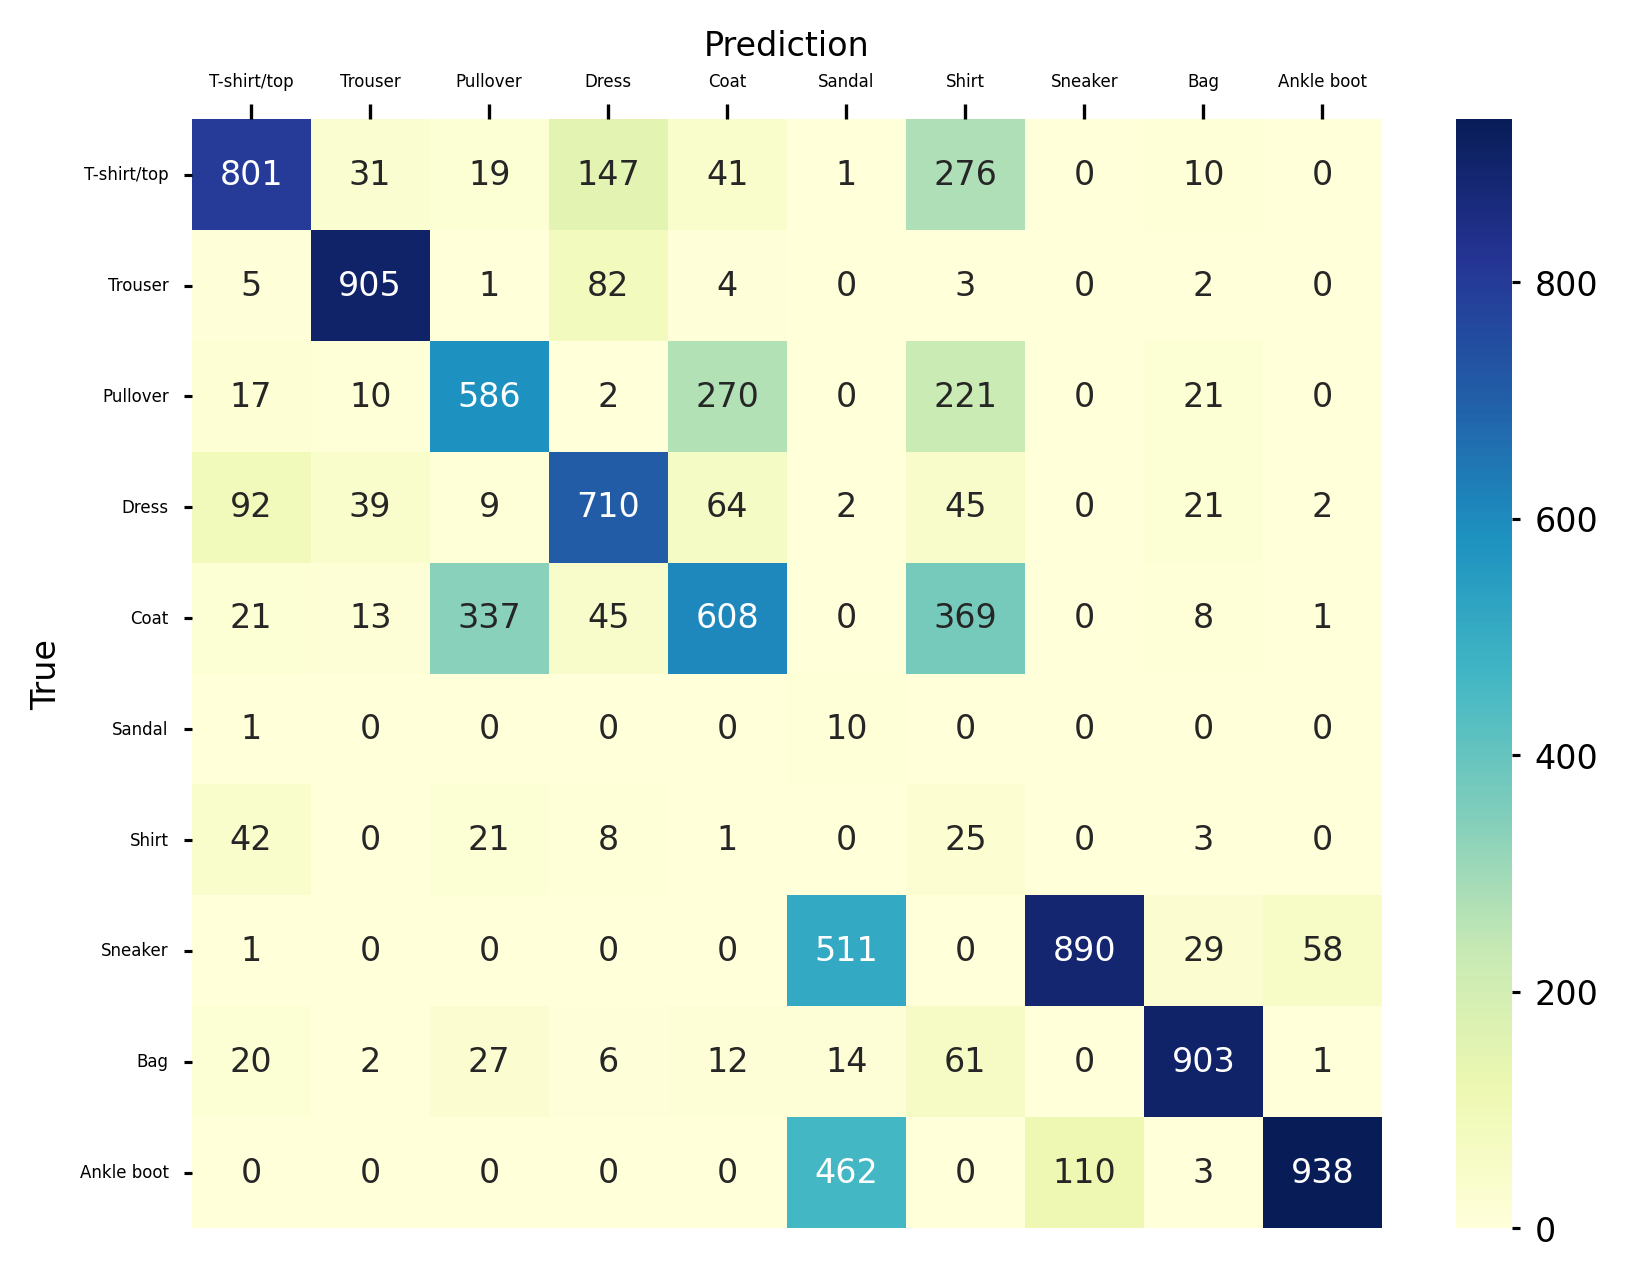

In [ ]:
cm = np.zeros((len(classes),len(classes)))
test_loader = DataLoader(test_data,batch_size=1)
for x,y in test_loader:
    pred = model(x.cuda())
    cm[pred.argmax(1),y]+=1
plt.rcParams.update({'ytick.major.size':2,'ytick.major.width':0.75})
fig,ax=plt.subplots(dpi=300)
ax=sn.heatmap(cm,xticklabels=classes,yticklabels=classes,annot=True,cmap="YlGnBu",fmt='g',annot_kws={"fontsize":8})
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


sn.set(font_scale=0.5)
ax.tick_params(labelsize=4)
ax.figure.axes[-1].tick_params(labelsize=8)
plt.xlabel('Prediction',fontsize=8)
plt.ylabel('True',fontsize=8)

plt.savefig("True_Prediction.png")

print("batch size= " + str(batch_size))
print("time" + str(elapse))
